<a href="https://colab.research.google.com/github/jprve/MS-Floorplan/blob/main/MS_StableDiffusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install diffusers[training] diffusers transformers scipy
# Install packages

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.0/280.0 kB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.7/536.7 kB 20.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.9/190.9 kB 22.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.8 MB/s eta 0:00:00


In [ ]:
import torch
from dataclasses import dataclass
from datasets import load_dataset, load_from_disk
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
from diffusers import DDPMScheduler, DDPMPipeline, UNet2DModel, StableDiffusionPipeline, DiffusionPipeline, UNet1DModel, UNet2DConditionModel
from diffusers.utils import make_image_grid
import os
import torch.nn.functional as F
from accelerate import Accelerator, notebook_launcher
from huggingface_hub import create_repo, upload_folder, notebook_login
from tqdm.auto import tqdm
from pathlib import Path
import glob

# Imports of libraries

In [ ]:
!sudo apt -qq install git-lfs
!git config --global credential.helper store


git-lfs is already the newest version (3.0.2-1ubuntu0.2).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


In [ ]:
@dataclass
class TrainingConfig:
    image_size = 128  # Generated Image Resolution
    train_batch_size = 16
    eval_batch_size = 16  # Sample batch size
    num_epochs = 50
    gradient_accumulation_steps = 1
    learning_rate = 1e-4
    lr_warmup_steps = 500
    save_image_epochs = 5 # Output sample images every 5 epochs
    save_model_epochs = 30 # Save model on every 30 epochs
    mixed_precision = "fp16"
    output_dir = "/content/drive/MyDrive/Colab Notebooks/ModelOutputs/StableDiff-Vanilla-V2"  # the model name locally and on the HF Hub
    hub_model_id = "jprve/StableDiff-Vanilla-V2"
    push_to_hub = True  # Push to HuggingFace after completion
    hub_private_repo = True
    overwrite_output_dir = True
    seed = 0


config = TrainingConfig()

In [ ]:
# Load Dataset from local when availble to save time and resources, loading can also be done via HuggingFace

dataset = load_dataset("imagefolder", data_dir="/content/drive/MyDrive/Colab Notebooks/dataset", split="train")

Resolving data files:   0%|          | 0/2831 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

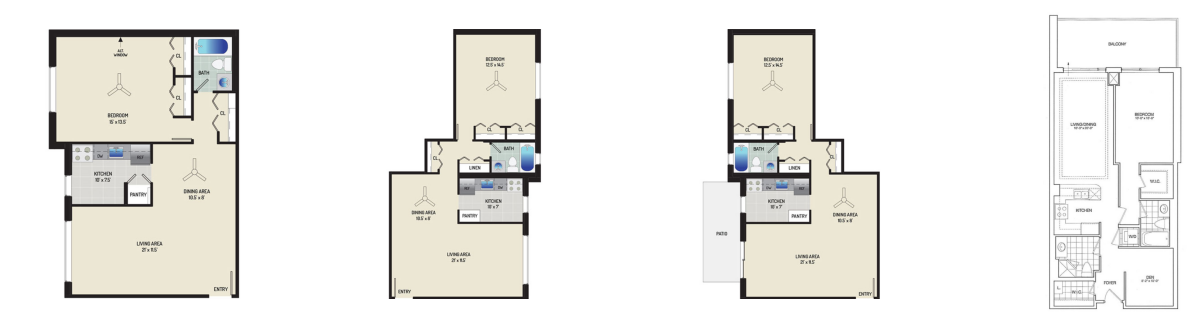

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i, image in enumerate(dataset[:4]["image"]):
    axs[i].imshow(image)
    axs[i].set_axis_off()
fig.show()

# Preview dataset

In [ ]:
preprocess = transforms.Compose(
    [
        transforms.Resize((config.image_size, config.image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ]
)

# Transformations to normalisze images

In [ ]:
def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    return {"images": images}


dataset.set_transform(transform)

In [ ]:
train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=config.train_batch_size, shuffle=True)

In [ ]:
model = UNet2DModel(
    # Set target image resolution
    sample_size=config.image_size,
    # 3 for RGB Channels
    in_channels=3,
    out_channels=3,
    layers_per_block=2,  # ResNet layers in a single block on the architecture
    block_out_channels=(128, 128, 128, 256, 256, 256, 512, 512,),  # Resolution for each block
    down_block_types=(
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",
        "DownBlock2D"
    ),
    up_block_types=(
        "UpBlock2D",
        "AttnUpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D"
    ),
)

In [ ]:
sample_image = dataset[0]["images"].unsqueeze(0)
print("Input shape:", sample_image.shape)

print("Output shape:", model(sample_image, timestep=0).sample.shape)

# Preview image input and output shape when going through model

Input shape: torch.Size([1, 3, 128, 128])
Output shape: torch.Size([1, 3, 128, 128])


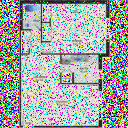

In [ ]:
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
noise = torch.randn(sample_image.shape)
timesteps = torch.LongTensor([50])
noisy_image = noise_scheduler.add_noise(sample_image, noise, timesteps)

Image.fromarray(((noisy_image.permute(0, 2, 3, 1) + 1.0) * 127.5).type(torch.uint8).numpy()[0])

# Add sample noise to image

In [ ]:
noise_pred = model(noisy_image, timesteps).sample
loss = F.mse_loss(noise_pred, noise)

# Loss and Noise prediction

In [ ]:
from diffusers.optimization import get_cosine_schedule_with_warmup

optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmup_steps,
    num_training_steps=(len(train_dataloader) * config.num_epochs),
)

In [ ]:
def evaluate(config, epoch, pipeline):
    images = pipeline(
        batch_size=config.eval_batch_size,
        generator=torch.manual_seed(config.seed),
    ).images

    image_grid = make_image_grid(images, rows=4, cols=4)

    test_dir = os.path.join(config.output_dir, "samples")
    os.makedirs(test_dir, exist_ok=True)
    image_grid.save(f"{test_dir}/{epoch:04d}.png")

# Evaluation method for images produced by generator

In [ ]:
def train_loop(config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler):
    accelerator = Accelerator(
        mixed_precision=config.mixed_precision,
        gradient_accumulation_steps=config.gradient_accumulation_steps,
        log_with="tensorboard",
        project_dir=os.path.join(config.output_dir, "logs"),
    )
    if accelerator.is_main_process:
        if config.output_dir is not None:
            os.makedirs(config.output_dir, exist_ok=True)
        if config.push_to_hub:
            repo_id = create_repo(
                repo_id=config.hub_model_id or Path(config.output_dir).name, exist_ok=True
            ).repo_id
        accelerator.init_trackers("train_example")

# Set up of accelerator to take model, optimizer, dataloader and the scheduler
    model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        model, optimizer, train_dataloader, lr_scheduler
    )

    global_step = 0

# Create status information of training

    for epoch in range(config.num_epochs):
        progress_bar = tqdm(total=len(train_dataloader), disable=not accelerator.is_local_main_process)
        progress_bar.set_description(f"Epoch {epoch}")

        for step, batch in enumerate(train_dataloader):
            clean_images = batch["images"]

            noise = torch.randn(clean_images.shape, device=clean_images.device)
            bs = clean_images.shape[0]

            timesteps = torch.randint(
                0, noise_scheduler.config.num_train_timesteps, (bs,), device=clean_images.device,
                dtype=torch.int64
            )

            noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

            with accelerator.accumulate(model):
                noise_pred = model(noisy_images, timesteps, return_dict=False)[0]
                loss = F.mse_loss(noise_pred, noise)
                accelerator.backward(loss)

                accelerator.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()

            progress_bar.update(1)
            logs = {"loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0], "step": global_step}
            progress_bar.set_postfix(**logs)
            accelerator.log(logs, step=global_step)
            global_step += 1

        if accelerator.is_main_process:
            pipeline = DDPMPipeline(unet=accelerator.unwrap_model(model), scheduler=noise_scheduler)

            if (epoch + 1) % config.save_image_epochs == 0 or epoch == config.num_epochs - 1:
                evaluate(config, epoch, pipeline)

            if (epoch + 1) % config.save_model_epochs == 0 or epoch == config.num_epochs - 1:
                if config.push_to_hub:
                    upload_folder(
                        repo_id=repo_id,
                        folder_path=config.output_dir,
                        commit_message=f"Epoch {epoch}",
                        ignore_patterns=["step_*", "epoch_*"],
                    )
                else:
                    pipeline.save_pretrained(config.output_dir)

In [ ]:
args = (config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler)

notebook_launcher(train_loop, args, num_processes=1)

Launching training on one GPU.


  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

events.out.tfevents.1709209419.c79c50c2f32c.484.0:   0%|          | 0.00/674k [00:00<?, ?B/s]

  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

events.out.tfevents.1709209419.c79c50c2f32c.484.0:   0%|          | 0.00/1.12M [00:00<?, ?B/s]

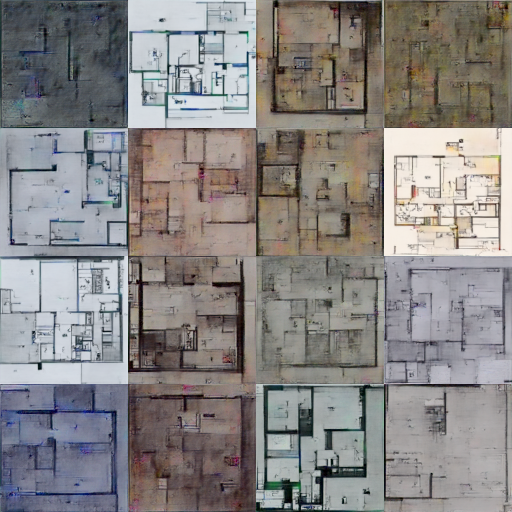

In [ ]:
sample_images = sorted(glob.glob(f"{config.output_dir}/samples/*.png"))
Image.open(sample_images[-1])

In [ ]:
# Pushing Model to HuggingFace for later usage

model.push_to_hub('jprve/StableDiff-Vanilla-V2')

diffusion_pytorch_model.safetensors:   0%|          | 0.00/505M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/jprve/StableDiff-Vanilla-V2/commit/c1e88aad46ec11edb4c271d81c0f242a6e938ff8', commit_message='Upload model', commit_description='', oid='c1e88aad46ec11edb4c271d81c0f242a6e938ff8', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
# Pushing Dataset to HuggingFace for later usage

dataset.push_to_hub('jprve/FloorPlansV2')

Uploading the dataset shards:   0%|          | 0/2 [00:00<?, ?it/s]

Map:   0%|          | 0/1416 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/15 [00:00<?, ?ba/s]

Map:   0%|          | 0/1415 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/15 [00:00<?, ?ba/s]

CommitInfo(commit_url='https://huggingface.co/datasets/jprve/FloorPlansV2/commit/831b2dcfef7b2bd3e64676ecbd6489b25992eff9', commit_message='Upload dataset', commit_description='', oid='831b2dcfef7b2bd3e64676ecbd6489b25992eff9', pr_url=None, pr_revision=None, pr_num=None)